# Here we train VQ-VAE 

In [1]:
import os
import gc
import sys
import cv2
import glob
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

!pip install accelerate
from accelerate import Accelerator

from functools import partial
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

!pip install colorama
from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
!pip install kaggle
!kaggle datasets download -d splcher/animefacedataset
!unzip animefacedataset.zip -d animefacedataset

import random
import os
import numpy as np
import torch
import glob

config = {'lr': 1e-3,
          'wd': 1e-2,
          'bs': 256,
          'img_size': 128,
          'epochs': 25,
          'seed': 1000}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

data_dir = 'animefacedataset/images'
image_files = glob.glob(os.path.join(data_dir, '*.jpg'))

print(f'Found {len(image_files)} image files.')

train_ratio = 0.9
num_train = int(len(image_files) * train_ratio)
num_valid = len(image_files) - num_train

train_paths = np.random.choice(image_files, num_train, replace=False)
valid_paths = np.setdiff1d(image_files, train_paths)

print(f'Split {len(image_files)} image files into {len(train_paths)} training files and {len(valid_paths)} validation files.')


Streaming output truncated to the last 5000 lines.
  inflating: animefacedataset/images/62766_2019.jpg  
  inflating: animefacedataset/images/62767_2019.jpg  
  inflating: animefacedataset/images/62768_2019.jpg  
  inflating: animefacedataset/images/62769_2019.jpg  
  inflating: animefacedataset/images/6276_2003.jpg  
  inflating: animefacedataset/images/62770_2019.jpg  
  inflating: animefacedataset/images/62771_2019.jpg  
  inflating: animefacedataset/images/62772_2019.jpg  
  inflating: animefacedataset/images/62773_2019.jpg  
  inflating: animefacedataset/images/62774_2019.jpg  
  inflating: animefacedataset/images/62775_2019.jpg  
  inflating: animefacedataset/images/62776_2019.jpg  
  inflating: animefacedataset/images/62777_2019.jpg  
  inflating: animefacedataset/images/62778_2019.jpg  
  inflating: animefacedataset/images/62779_2019.jpg  
  inflating: animefacedataset/images/6277_2003.jpg  
  inflating: animefacedataset/images/62780_2019.jpg  
  inflating: animefacedataset/ima

# main

In [3]:
import torch
torch.cuda.is_available()

True

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace animefacedataset/images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Found 63565 image files.
Split 63565 image files into 57208 training files and 6357 validation files.


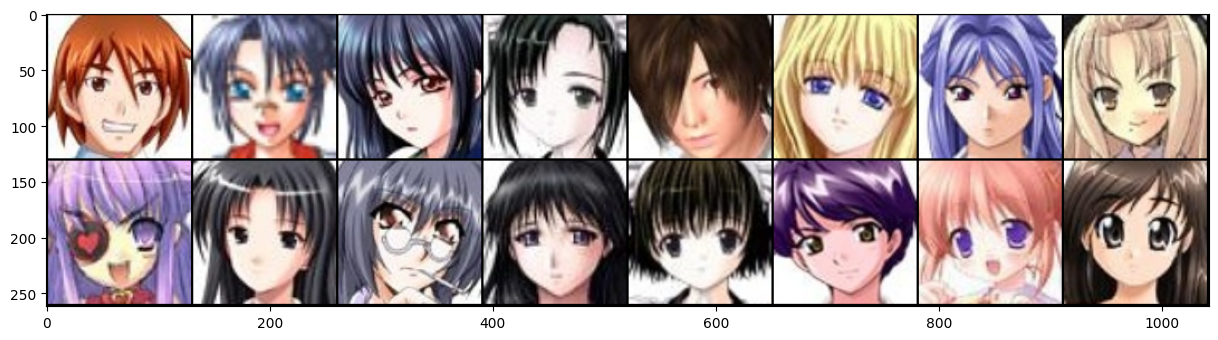

In [4]:
!pip install -q kaggle albumentations
!kaggle datasets download -d splcher/animefacedataset
!unzip -q animefacedataset.zip -d animefacedataset

import random
import os
import numpy as np
import torch
import glob
import cv2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

config = {'lr': 1e-3,
          'wd': 1e-2,
          'bs': 256,
          'img_size': 128,
          'epochs': 25,
          'seed': 1000}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

# Assuming the images are stored in 'animefacedataset/images'
data_dir = 'animefacedataset/images'
image_files = glob.glob(os.path.join(data_dir, '*.jpg'))

print(f'Found {len(image_files)} image files.')

# Split into training and validation sets
train_ratio = 0.9
num_train = int(len(image_files) * train_ratio)
num_valid = len(image_files) - num_train

train_paths = np.random.choice(image_files, num_train, replace=False)
valid_paths = np.setdiff1d(image_files, train_paths)

print(f'Split {len(image_files)} image files into {len(train_paths)} training files and {len(valid_paths)} validation files.')

def get_train_transforms():
    return A.Compose(
        [
            A.Resize(config['img_size'], config['img_size'], always_apply=True),
            ToTensorV2(p=1.0)
        ])

class ImageNetDataset(Dataset):
    def __init__(self, paths, augmentations):
        self.paths = paths
        self.augmentations = augmentations

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']

        # Divide by 255 to normalize the image between 0 and 1
        image = image / 255.0

        return image

    def __len__(self):
        return len(self.paths)

test_dataset = ImageNetDataset(valid_paths, augmentations=get_train_transforms())
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

dataiter = iter(test_dl)
sample = next(dataiter)  # Use next() instead of dataiter.next()

img = torchvision.utils.make_grid(sample).permute(1, 2, 0).numpy()
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()


In [5]:
class VQ(nn.Module):

    def __init__(self,num_embeddings=512,embedding_dim=64,commitment_cost=0.25):
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(self.num_embeddings,self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings,1/self.num_embeddings)

    def forward(self,inputs):
        inputs = inputs.permute(0,2,3,1).contiguous()
        input_shape = inputs.shape

        flat_inputs = inputs.view(-1,self.embedding_dim)

        distances = torch.cdist(flat_inputs,self.embeddings.weight)
        encoding_index = torch.argmin(distances,dim=1)

        quantized = torch.index_select(self.embeddings.weight,0,encoding_index).view(input_shape)

        e_latent_loss = F.mse_loss(quantized.detach(),inputs)
        q_latent_loss = F.mse_loss(quantized,inputs.detach())
        c_loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()

        quantized = quantized.permute(0,3,1,2).contiguous()
        return c_loss, quantized

In [6]:
class ResudialBlock(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels):
        super(ResudialBlock,self).__init__()
        self.resblock = nn.Sequential(nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels,hidden_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(hidden_channels,out_channels,kernel_size=1,stride=1,bias=False))
    def forward(self,x):
        return x + self.resblock(x)

class ResudialStack(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels,num_res_layers):
        super(ResudialStack,self).__init__()
        self.num_res_layers = num_res_layers
        self.layers = nn.ModuleList([ResudialBlock(in_channels,out_channels,hidden_channels) for _ in range(num_res_layers)])

    def forward(self,x):
        for i in range(self.num_res_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [7]:
class Model(nn.Module):

    def __init__(self,num_embeddings=512,embedding_dim=64,commitment_cost=0.25):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        #encode
        self.conv1 = nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1)
        self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
        self.conv3 = nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)
        self.resblock1 = ResudialStack(128,128,64,3)

        #vq
        self.vq_conv = nn.Conv2d(128,self.embedding_dim,kernel_size=1,stride=1)
        self.vq = VQ(self.num_embeddings,self.embedding_dim,self.commitment_cost)

        #decode
        self.conv4 = nn.Conv2d(self.embedding_dim,64,kernel_size=3,stride=1,padding=1)
        self.resblock2 = ResudialStack(64,64,32,3)
        self.conv5 = nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1)
        self.conv6 = nn.ConvTranspose2d(32,3,kernel_size=4,stride=2,padding=1)


    def encode(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.resblock1(x)
        return x

    def decode(self,quantized):
        x = self.conv4(quantized)
        x = self.resblock2(x)
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        return x

    def forward(self,inputs):
        x = self.encode(inputs)
        c_loss,quantized =  self.vq(self.vq_conv(x))
        outputs = self.decode(quantized)
        rec_loss = F.mse_loss(outputs,inputs)
        loss = rec_loss + c_loss
        return loss,outputs,rec_loss

cuda is used
Epoch Started:0
Epoch:0 |Train Loss:2.5116150403129205|Valid Loss:0.06880846828222274|Rec Loss:0.03562352746725082
Loss Decreased from 9999999 to 0.03562352746725082
Time taken by epoch 0 is 113.05s
Epoch Started:1
Epoch:1 |Train Loss:0.2387415890282552|Valid Loss:0.03383678704500198|Rec Loss:0.023361224085092544
Loss Decreased from 0.03562352746725082 to 0.023361224085092544
Time taken by epoch 1 is 89.37s
Epoch Started:2
Epoch:2 |Train Loss:0.0271131272061861|Valid Loss:0.019293062090873718|Rec Loss:0.013052028082311153
Loss Decreased from 0.023361224085092544 to 0.013052028082311153
Time taken by epoch 2 is 88.25s
Epoch Started:3
Epoch:3 |Train Loss:0.01713346768519841|Valid Loss:0.014825741238892078|Rec Loss:0.009189607687294482
Loss Decreased from 0.013052028082311153 to 0.009189607687294482
Time taken by epoch 3 is 89.94s
Epoch Started:4
Epoch:4 |Train Loss:0.01277672196322653|Valid Loss:0.01132175836712122|Rec Loss:0.007667823527008295
Loss Decreased from 0.00918960

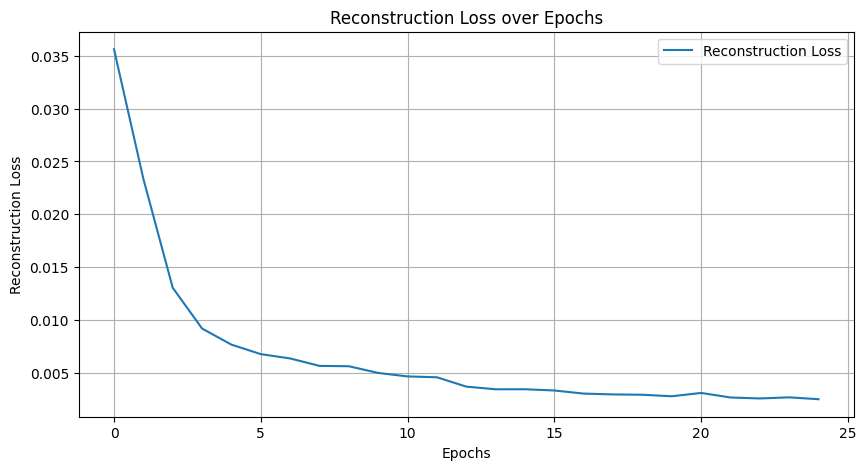

0.0025003806501626966

In [8]:
import matplotlib.pyplot as plt

def run():
    def evaluate(model, valid_loader):
        model.eval()
        valid_loss = 0
        rec_loss = 0
        with torch.no_grad():
            for i, inputs in enumerate(valid_loader):
                loss, _, loss2 = model(inputs)
                valid_loss += loss.item()
                rec_loss += loss2.item()

        valid_loss /= len(valid_loader)
        rec_loss /= len(valid_loader)
        return valid_loss, rec_loss

    def train_and_evaluate_loop(train_loader, valid_loader, model, optimizer, epoch, best_loss, lr_scheduler=None):
        train_loss = 0
        for i, inputs in enumerate(train_loader):
            optimizer.zero_grad()
            model.train()
            loss, _, _ = model(inputs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if lr_scheduler:
                lr_scheduler.step()

        train_loss /= len(train_loader)
        valid_loss, rec_loss = evaluate(model, valid_loader)

        print(f"Epoch:{epoch} |Train Loss:{train_loss}|Valid Loss:{valid_loss}|Rec Loss:{rec_loss}")

        if rec_loss <= best_loss:
            print(f"Loss Decreased from {best_loss} to {rec_loss}")

            best_loss = rec_loss
            torch.save(model.state_dict(), './imagenet_vq_vae_model.bin')

        return best_loss, rec_loss

    accelerator = Accelerator()
    print(f"{accelerator.device} is used")

    model = Model()

    # Train
    train_dataset = ImageNetDataset(train_paths, augmentations=get_train_transforms())
    train_dl = DataLoader(train_dataset, batch_size=config['bs'], shuffle=True, num_workers=4)

    # Valid
    valid_dataset = ImageNetDataset(valid_paths, augmentations=get_train_transforms())
    valid_dl = DataLoader(valid_dataset, batch_size=config['bs'], shuffle=False, num_workers=4)

    optimizer = optim.Adam(model.parameters(), lr=config['lr'], amsgrad=False)
    lr_scheduler = None

    model, train_dl, valid_dl, optimizer, lr_scheduler = accelerator.prepare(model, train_dl, valid_dl, optimizer, lr_scheduler)

    best_loss = 9999999
    start_time = time.time()
    rec_losses = []

    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss, rec_loss = train_and_evaluate_loop(train_dl, valid_dl, model, optimizer, epoch, best_loss, lr_scheduler)
        rec_losses.append(rec_loss)

        end_time = time.time()
        print(f"Time taken by epoch {epoch} is {end_time - start_time:.2f}s")
        start_time = end_time

    # Plot reconstruction loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(config["epochs"]), rec_losses, label='Reconstruction Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Reconstruction Loss')
    plt.title('Reconstruction Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_loss
run()

In [ ]:
def generate_and_save_images(model,test_sample,figsize=(20,15)):
    f, axarr = plt.subplots(1,2,figsize=figsize)
    img= torchvision.utils.make_grid(test_sample).permute(1,2,0).numpy()
    axarr[0].imshow(img)
    plt.title("Orignal")

    _,outputs,_ = model(test_sample)
    predictions = outputs.detach().cpu()
    img = torchvision.utils.make_grid(predictions).permute(1,2,0).numpy()

    plt.savefig('image.png')
    axarr[1].imshow(img)
    plt.title("Reconstruction")


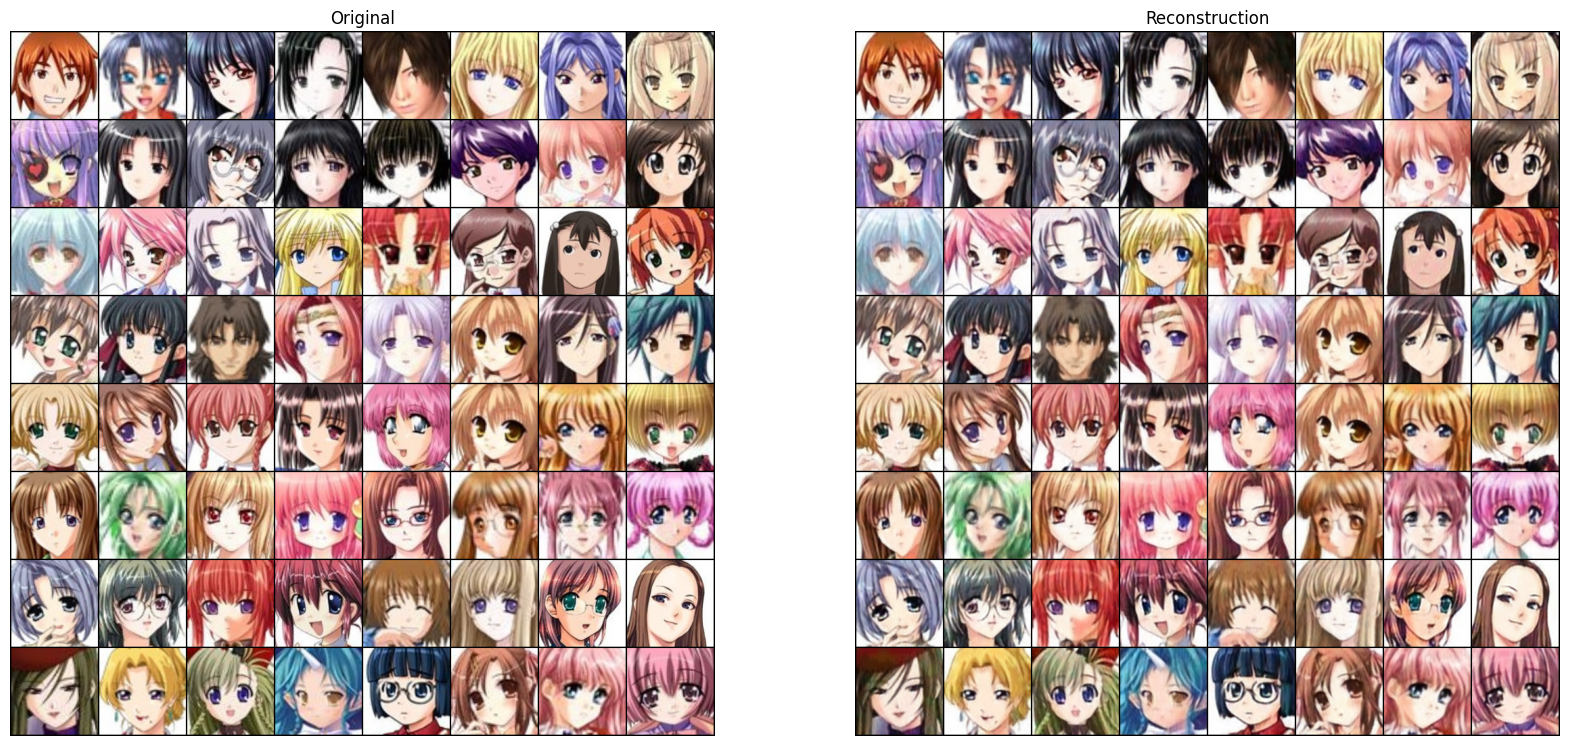

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

def generate_and_save_images(model, test_sample, figsize=(20, 15)):
    model.eval()
    with torch.no_grad():
        f, axarr = plt.subplots(1, 2, figsize=figsize)

        img = torchvision.utils.make_grid(test_sample).permute(1, 2, 0).numpy()
        axarr[0].imshow(img)
        axarr[0].set_title("Original")
        axarr[0].axis('off')

        _, outputs, _ = model(test_sample)
        predictions = outputs.detach().cpu()

        img = torchvision.utils.make_grid(predictions).permute(1, 2, 0).numpy()
        axarr[1].imshow(img)
        axarr[1].set_title("Reconstruction")
        axarr[1].axis('off')

        plt.savefig('image.png')
        plt.show()

model = Model()
model.load_state_dict(torch.load('./imagenet_vq_vae_model.bin'))
model.eval()

test_dataset = ImageNetDataset(valid_paths, augmentations=get_train_transforms())
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

dataiter = iter(test_dl)
sample = next(dataiter)

generate_and_save_images(model, sample)


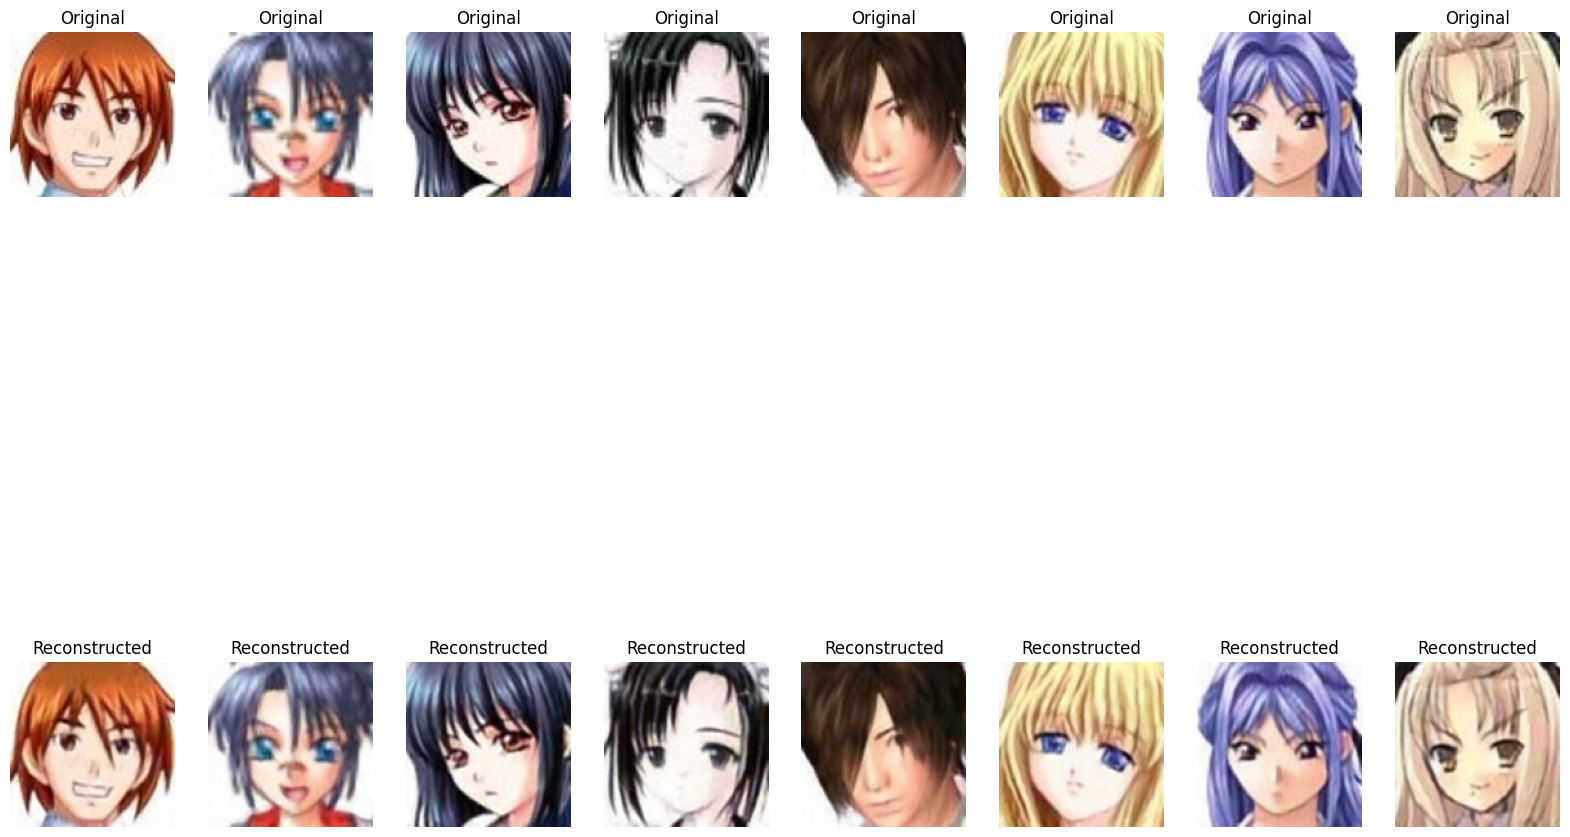

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

def generate_and_save_images(model, test_sample, num_images=8, figsize=(20, 15)):
    model.eval()
    with torch.no_grad():
        f, axarr = plt.subplots(2, num_images, figsize=figsize)

        for i in range(num_images):
            img = test_sample[i].permute(1, 2, 0).numpy()
            axarr[0, i].imshow(img)
            axarr[0, i].axis('off')
            axarr[0, i].set_title("Original")

        _, outputs, _ = model(test_sample[:num_images])
        predictions = outputs.detach().cpu()

        for i in range(num_images):
            img = predictions[i].permute(1, 2, 0).numpy()
            axarr[1, i].imshow(img)
            axarr[1, i].axis('off')
            axarr[1, i].set_title("Reconstructed")

        plt.savefig('image.png')
        plt.show()

model = Model()
model.load_state_dict(torch.load('./imagenet_vq_vae_model.bin'))
model.eval()

test_dataset = ImageNetDataset(valid_paths, augmentations=get_train_transforms())
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

dataiter = iter(test_dl)
sample = next(dataiter)

generate_and_save_images(model, sample, num_images=8)
